In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from typing import List, Dict
from win32com import client #для подключения к OpenServer 
from sklearn.metrics import mean_squared_error
from scipy import optimize

### Загрузка готовой сводной таблицы

In [35]:
# Чтение сводной таблицы, обединенной из выгрузки ШТР и файлов с давлениями от НТЦ
df = pd.read_csv('pivot_table_shtr_pres_en.csv', 
                  sep= ';', encoding = "windows-1251", parse_dates=['measure_date'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30799 entries, 0 to 30798
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   well_name                  30799 non-null  object        
 1   year                       30799 non-null  int64         
 2   month                      30799 non-null  int64         
 3   character_x                28794 non-null  object        
 4   character_y                26994 non-null  object        
 5   equipment_name             28728 non-null  object        
 6   exploitation_name          28761 non-null  object        
 7   field                      28795 non-null  object        
 8   measure_date               30799 non-null  datetime64[ns]
 9   measure_date_new           28795 non-null  object        
 10  rig                        28591 non-null  object        
 11  state                      28795 non-null  object        
 12  bhp 

In [37]:
df.head(2)

,well_name,year,month,character_x,character_y,equipment_name,exploitation_name,field,measure_date,measure_date_new,rig,state,bhp,downtime,f_rotat,f_rotat_tm,gas_factor,layer_pres_calc,layer_pres_research,p_ag_line,p_annular,p_annular_tm,p_bottomhole_research,p_buff,p_buff_tm,p_intake_accel,p_intake_accel_tm,p_layer,p_line,p_line_tm,q_fluid,q_fluid_tm,q_gaz,q_gaz_tm,q_oil,t_work_tm,wcutting,worktime,layer_pres_research_count
0,1003,2021,5,NaN,NaN,NaN,NaN,NaN,2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.833235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,1003,2021,6,Нефтяная,NaN,МТ5А-125-2350,Электропогружным насосом,Новопортовское,2021-06-01,2021-06-05,21.00,ВНР,NaN,NaN,35.0,NaN,184.242304,NaN,NaN,35.396202,47.04107,NaN,NaN,48.517037,NaN,140.61058,NaN,187.45125,35.254345,NaN,129.777778,133.66667,19468.407407,20407.56,105.66741,NaN,4.594445,24.0,3


In [38]:
well_name = '4085'
#  Выборка для отладки
test_df_full = df.query('well_name == @well_name').reset_index(drop=True)
test_df = test_df_full.query('layer_pres_research > 0').reset_index()
test_df

,index,well_name,year,month,character_x,character_y,equipment_name,exploitation_name,field,measure_date,measure_date_new,rig,state,bhp,downtime,f_rotat,f_rotat_tm,gas_factor,layer_pres_calc,layer_pres_research,p_ag_line,p_annular,p_annular_tm,p_bottomhole_research,p_buff,p_buff_tm,p_intake_accel,p_intake_accel_tm,p_layer,p_line,p_line_tm,q_fluid,q_fluid_tm,q_gaz,q_gaz_tm,q_oil,t_work_tm,wcutting,worktime,layer_pres_research_count
0,17,4085,2018,1,Нефтяная,Нефтяная,SN-8000-2100,Электропогружным насосом,Новопортовское,2018-01-01,2018-01-01,4.00,В работе,145.236486,NaN,40.0,NaN,772.704772,165.830452,165.732385,NaN,73.673080,NaN,144.92514,37.261452,NaN,136.769137,NaN,175.29225,25.694059,NaN,583.709677,NaN,354582.000000,NaN,458.88420,NaN,7.419355,24.000000,4
1,41,4085,2020,1,Нефтяная,Нефтяная,SN-8000-2100,Электропогружным насосом,Новопортовское,2020-01-01,2020-01-01,4.00,В работе,160.436794,NaN,41.0,40.0,1729.441036,170.390544,172.989306,23.773638,111.933380,109.553505,147.77971,57.583347,55.218075,152.032922,152.12411,168.90877,29.716876,27.256424,225.390345,250.31035,303314.734375,328778.20,175.38310,23.446,7.158621,24.000000,4
2,50,4085,2020,10,Нефтяная,Нефтяная,Фонтанный лифт с ТМСП,Фонтанный,Новопортовское,2020-10-01,2020-10-01,4.00,В работе,174.362237,NaN,NaN,NaN,1980.153283,176.813900,176.813900,21.598776,142.192750,144.282420,169.63830,124.021800,124.839150,168.229898,168.22989,184.06024,25.648735,25.692642,125.766667,126.00000,209564.233333,209786.36,105.83233,NaN,1.000000,24.000000,4
3,86,4085,2023,10,Нефтяная,Нефтяная,Фонтанный лифт с ТМСП,Фонтанный,Новопортовское,2023-10-01,2023-10-01,4.00,В работе,150.041745,23.981112,NaN,NaN,3090.507690,151.218543,149.649479,24.776495,121.779144,121.779144,169.63830,101.755631,101.772520,142.397936,142.35065,162.32265,29.443356,29.899319,70.916667,71.71429,183195.000000,188842.14,59.27667,NaN,1.881667,6.014166,4


In [40]:
test_df[['index', 'layer_pres_research']]

,index,layer_pres_research
0,17,165.732385
1,41,172.989306
2,50,176.813900
3,86,149.649479


In [41]:
# Подключаемся к OpenServer
Server = client.Dispatch('PX32.OpenServer.1')

### Калькулятор для всех методов

In [43]:
class PressureCalculator:
    def __init__(self, server, fact_df: pd.DataFrame):

        self.server = server
        self.fact_df = fact_df

        self.intake_pres_calc = []
        self.bhp_pres_calc = []
        self._layer_pres_calc= []
        self.error_bar = []
        self._best_params = None
        self.sign = 0

    def _calc_weight_list(self, y_count: int) -> List[float]:
        '''Функция рассчитывает веса для MSE'''
        # Задаем веса, для последнего значения наибольший вес
        left_bound = 0.1
        right_bound = 1
        weigth = 0
        result = []
        for i in range(1, y_count + 1):
            arr = [x for x in range(1, y_count + 1)]
            # Минимаксная нормализация весов в заданном диапазоне
            weigth = round(left_bound + (i - min(arr)) / (max(arr) - min(arr))
                        * (right_bound - left_bound), 
                        2)
            result.append(weigth)
        return result   
    
    def fit_shgo_1point(self, x: float) -> float:
        '''Функция для оптимизации, заносит данные в секцию Gradient, 
        достает рассчитанное Рпл'''
        # На каждой итерации обнуляем списки с давлениями
        self.intake_pres_calc = []
        self.bhp_pres_calc = []
        self._layer_pres_calc = []
        self.error_bar = []
        
        # Вносим параметры трубы
        depth = self.server.GetValue('PROSPER.SIN.EQP.Down.Data[2].Depth')
        self.server.SetValue('PROSPER.SIN.EQP.Down.Data[3].Depth', float(depth) + x[0])
        print(f'Параметр {x[0]}')

        try:
            # Берем значения из 3й строки (индекс = 2)
            for _, row in self.fact_df.iloc[2:3].iterrows():
                # Заполняем секцию Gradient фактическими данными
                self.server.SetValue('PROSPER.ANL.GRD.Pres', row['p_intake_accel'])
                self.server.SetValue('PROSPER.ANL.GRD.WC', row['wcutting'])
                self.server.SetValue('PROSPER.ANL.GRD.GOR', row['gas_factor'] * 0.85) #переводим из м3/т в м3/м3
                self.server.SetValue('PROSPER.ANL.GRD.Rate', row['q_fluid'])
                print(row['p_intake_accel'])
                # Запускает расчет в секции Gradient
                self.server.DoCommand('PROSPER.ANL.GRD.CALC')

                # Создаем список значений из столбца с давлением
                regimes = self.server.GetValue('PROSPER.OUT.GRD.RES[0][0][$].Regime').split('|')[:-1]

                # Найдем номер строки с данными на глубине приема ЭЦН
                intake_index = regimes.index('Pump Intake') + 1
                # Найдем номер строки с данными на забое
                bhp_index = regimes.index('Gauge GradPoint7-BH') + 1
                # Найдем номер строки с данными в пласте
                layer_index = len(regimes) - 1

                # Создадим список значений расчетного Рприем
                self.intake_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{intake_index}].Pres'))
                # Создадим список значений расчетного Рзаб
                self.bhp_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{bhp_index}].Pres'))
                # Создадим список значений расчетного Рпл
                self._layer_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{layer_index}].Pres'))

                # Для отображения планок погрешности на графиках рассчитаем отклонение
                self.error_bar = list(self.fact_df['layer_pres_research'] * 0.1)

                print(f'Рпл расчетное = {self._layer_pres_calc}')
        except ValueError:
            print('Расчет не может быть выполнен')
            pass

        # Из Prosper выгружаются значения str, преобразуем в вещественный
        self._layer_pres_calc = [float(x) for x in self._layer_pres_calc]

        delta = abs(self._layer_pres_calc - self.fact_df.loc[2:2, 'layer_pres_research'])
        print(f'Дельта: {round(delta, 1)} бар', '\n')
        return delta

    def fit_shgo(self, x: float) -> float:
        '''Функция для оптимизации, заносит данные в секцию Gradient, 
        достает рассчитанное Рпл'''
        # На каждой итерации обнуляем списки с давлениями
        self.intake_pres_calc = []
        self.bhp_pres_calc = []
        self._layer_pres_calc = []
        self.error_bar = []
        
        # Вносим параметры трубы
        depth = self.server.GetValue('PROSPER.SIN.EQP.Down.Data[2].Depth')
        self.server.SetValue('PROSPER.SIN.EQP.Down.Data[3].Depth', float(depth) + x[0])
        print(f'Параметр {x[0]}')

        try:
            # Берем значения из 3й строки (индекс = 2)
            for _, row in self.fact_df.iterrows():
                # Заполняем секцию Gradient фактическими данными
                self.server.SetValue('PROSPER.ANL.GRD.Pres', row['p_intake_accel'])
                self.server.SetValue('PROSPER.ANL.GRD.WC', row['wcutting'])
                self.server.SetValue('PROSPER.ANL.GRD.GOR', row['gas_factor'] * 0.85) #переводим из м3/т в м3/м3
                self.server.SetValue('PROSPER.ANL.GRD.Rate', row['q_fluid'])

                # Запускает расчет в секции Gradient
                self.server.DoCommand('PROSPER.ANL.GRD.CALC')

                # Создаем список значений из столбца с давлением
                regimes = self.server.GetValue('PROSPER.OUT.GRD.RES[0][0][$].Regime').split('|')[:-1]

                # Найдем номер строки с данными на глубине приема ЭЦН
                intake_index = regimes.index('Pump Intake') + 1
                # Найдем номер строки с данными на забое
                bhp_index = regimes.index('Gauge GradPoint7-BH') + 1
                # Найдем номер строки с данными в пласте
                layer_index = len(regimes) - 1

                # Создадим список значений расчетного Рприем
                self.intake_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{intake_index}].Pres'))
                # Создадим список значений расчетного Рзаб
                self.bhp_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{bhp_index}].Pres'))
                # Создадим список значений расчетного Рпл
                self._layer_pres_calc.append(self.server.GetValue(
                    f'PROSPER.OUT.GRD.RES[0][0][{layer_index}].Pres'))

                # Для отображения планок погрешности на графиках рассчитаем отклонение
                self.error_bar = list(self.fact_df['layer_pres_research'] * 0.1)

                # print(f'Рпл расчетное = {self._layer_pres_calc}')
        except ValueError:
            print('Расчет не может быть выполнен')
            pass

        # Из Prosper выгружаются значения str, преобразуем в вещественный
        self._layer_pres_calc = [float(x) for x in self._layer_pres_calc]

        # Рассчитаем веса, подаем количество значений Рпл по ГДИС
        weight_list = self._calc_weight_list(self.fact_df['layer_pres_research'].count())

        # Найдем корень из среднеквадратичной ошибки между факт. и рассчетным Рпл, 
        rmse = mean_squared_error(self.fact_df['layer_pres_research'].values, 
                                  self._layer_pres_calc,
                                  sample_weight=weight_list,    # зададим веса для каждой MSE
                                  squared=False)
        print(f'Среднеквадратичная ошибка Рпл: {round(rmse, 1)} бар', '\n')

        return rmse

    def fit(self, x: float) -> float:
        '''Функция для оптимизации, заносит данные в секцию Gradient, 
        достает рассчитанное Рпл'''
        # На каждой итерации обнуляем списки с давлениями
        self.intake_pres_calc = []
        self.bhp_pres_calc = []
        self.layer_pres_calc = []
        self.error_bar = []
        
        # Вносим параметры трубы
        depth = self.server.GetValue('PROSPER.SIN.EQP.Down.Data[2].Depth')
        self.server.SetValue('PROSPER.SIN.EQP.Down.Data[3].Depth', float(depth) + x)
        print(f'Параметр {x}')

        for _, row in self.fact_df.iterrows():
            # Заполняем секцию Gradient фактическими данными
            self.server.SetValue('PROSPER.ANL.GRD.Pres', row['p_intake_accel'])
            self.server.SetValue('PROSPER.ANL.GRD.WC', row['wcutting'])
            self.server.SetValue('PROSPER.ANL.GRD.GOR', row['gas_factor'] * 0.85) #переводим из м3/т в м3/м3
            self.server.SetValue('PROSPER.ANL.GRD.Rate', row['q_fluid'])

            # Запускает расчет в секции Gradient
            self.server.DoCommand('PROSPER.ANL.GRD.CALC')

            # Создаем список значений из столбца с давлением
            regimes = self.server.GetValue('PROSPER.OUT.GRD.RES[0][0][$].Regime').split('|')[:-1]

            # Найдем номер строки с данными на глубине приема ЭЦН
            intake_index = regimes.index('Pump Intake') + 1
            # Найдем номер строки с данными на забое
            bhp_index = regimes.index('Gauge GradPoint7-BH') + 1
            # Найдем номер строки с данными в пласте
            layer_index = len(regimes) - 1

            # Создадим список значений расчетного Рприем
            self.intake_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{intake_index}].Pres'))
            # Создадим список значений расчетного Рзаб
            self.bhp_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{bhp_index}].Pres'))
            # Создадим список значений расчетного Рпл
            self.layer_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{layer_index}].Pres'))
            
            # Для отображения планок погрешности на графиках рассчитаем отклонение
            self.error_bar = list(self.fact_df['layer_pres_research'] * 0.1)

        # Из Prosper выгружаются значения str, преобразуем в вещественный
        self.layer_pres_calc = [float(x) for x in self.layer_pres_calc]
   
        # Рассчитаем веса, подаем количество значений Рпл по ГДИС
        weight_list = self._calc_weight_list(self.fact_df['layer_pres_research'].count())

        # Найдем корень из среднеквадратичной ошибки между факт. и рассчетным Рпл, 
        rmse = mean_squared_error(self.fact_df['layer_pres_research'].values, 
                                  self.layer_pres_calc,
                                  sample_weight=weight_list,    # зададим веса для каждой MSE
                                  squared=False)
        print(f'Среднеквадратичная ошибка Рпл: {round(rmse, 1)} бар', '\n')

        if sum(self.layer_pres_calc) - sum(self.fact_df['layer_pres_research']) < 0:
            self.sign = -1
        else:
            self.sign = 1
        print(self.sign)
        self._set_params(x, err=rmse)
        return rmse

    def derrivative(self, x: float, dx) -> float:
        '''Вычисление среднего производных с промежутком до данной точки и промежутком после, 
        т.е. среднее от правой и левой производной.

        По определению для нахождения производной нужно взять приращение функции на данном промежутке 
        и разделить на приращение аргумента. f'(x) = (f(x + dx) - f(x)) / dx

        x - текущий параметр трубы '''

        return (self.fit(x + dx) - self.fit(x)) / dx

    def newtons_method(self, a, b, f):
        '''Метод Ньютона (метод касательных) чувствителен к выбору начальной точки.
        a, b - границы диапазона варьирования параметра х, используются для нахождения х;
        f - функция, которая принимает х,'''

        # Начальное значение параметра
        x0 = 280
        # Текущее значение параметра
        xn = x0 * 0.95
        
        dx = 0.1
        
        # Формула метода Ньютона приближенного решения уравнения вида f(x)=0.
        # Выражение описывает итерационный процесс нахождения приближенного корня уравнения вида f(x)=0
        xn1 = xn - self.fit(xn) / self.derrivative(xn, dx)
        print(f'До цикла xn {xn}, dx {dx}, xn1 {xn1}')
        # Выходим из цикла при приращении аргумента функции меньше указанного (0.001)
        while abs(xn1-xn) > 0.001:
            # Текущее значение параметра
            xn = xn1
            
            xn1 = xn - self.fit(xn) / self.derrivative(xn, dx)
            dx = 1
            print(f'xn {xn}, dx {dx}, xn1 {xn1}')
            print(f'Среднеквадратичная ошибка Рпл: {round(self.fit(xn), 1)} бар', '\n')
        return xn1

    def _set_params(self, x: float, err: float) -> Dict:
        '''Запоминаем RMSE и параметры в словаре'''
        # Если словарь пуст или текущая RMSE меньше предыдущей, то обновим словарь, 
        # иначе словарь не меняется
        if not self._best_params or err < self._best_params['err']:
            self._best_params = {'err': err, 'params': x}

    @property
    def best_params(self) -> Dict:
        '''Определяем лучшие параметры по минимальной RMSE'''
        # Если _best_params содержит значения, то вернем их, иначе None
        if self._best_params:
            return self._best_params['err'], self._best_params['params']
        return None

    def show_plot(self):
        plt.figure()
        plt.scatter(self.fact_df['index'], self.layer_pres_calc, color='red')
        plt.errorbar(self.fact_df['index'], self.fact_df['layer_pres_research'], 
                     yerr=self.error_bar, ecolor='gray')
        plt.xticks(rotation=90)
        plt.ylim(0, 300)
        plt.grid()
        plt.legend(['расчет', 'факт'])
        plt.show()

### Метод половинного деления

In [44]:
class PressureCalculatorStepByStep(PressureCalculator):
    
    def __init__(self, server, fact_df: pd.DataFrame):
        # Выполняем наследование методов класса PressureCalculator
        super().__init__(server, fact_df)
        self.best_length = 0
        self.best_diameter = 0
        self.best_roughness = 0

    def _calc_weight_list(self, y_count: int) -> List[float]:
        '''Функция рассчитывает веса для MSE
            y_count - суммарное количество значений Рпл по ГДИС
        '''
        # Задаем веса, для последнего значения наибольший вес
        left_bound = 0.1
        right_bound = 10
        weigth = 0
        result = []
        # Переберем все порядковые номера значений Рпл по ГДИС
        for i in range(1, y_count + 1):
            arr = [x for x in range(1, y_count + 1)]
            # Минимаксная нормализация весов в заданном диапазоне [a, b]:
            # a + (X - Xmin) / (Xmax - Xmin) * (b - a)
            weigth = round(left_bound + (i - min(arr)) / (max(arr) - min(arr))
                        * (right_bound - left_bound), 
                        2)
            # Добавим вес для текущего значения Рпл по ГДИС
            result.append(weigth)
        return result 

    def fit(self, x: float, 
                       param_name: str) -> float:
        '''Функция для оптимизации, заносит данные в секцию Gradient, 
        достает рассчитанное Рпл'''
        # На каждой итерации обнуляем списки с давлениями
        self.intake_pres_calc = []
        self.bhp_pres_calc = []
        self.layer_pres_calc = []
        self.error_bar = []

        if not param_name:
            print('Введи имя параметра: length, diameter, roughness')

        # Создаем список значений из столбца с названиями подземного оборудования
        equip = self.server.GetValue(
            'PROSPER.SIN.EQP.Down.Data[$].Type'
            ).split('|')[:-1]
        
        # Определим строку с доп. трубой
        add_casing_index = len(equip) - 1

        # Вносим параметры трубы
        depth = self.server.GetValue(f'PROSPER.SIN.EQP.Down.Data[{len(equip) - 2}].Depth')
        
        length = diameter = roughness = 0

        if param_name == 'length':
            length = float(depth) + x
            diameter = self.best_diameter
            roughness = self.best_roughness
        elif param_name == 'diameter':
            length = float(depth) + self.best_length
            diameter = x
            roughness = self.best_roughness
        elif param_name == 'roughness':
            length = float(depth) + self.best_length
            diameter = self.best_diameter
            roughness = x

        self.server.SetValue(f'PROSPER.SIN.EQP.Down.Data[{add_casing_index}].Depth', length)
        self.server.SetValue(f'PROSPER.SIN.EQP.Down.Data[{add_casing_index}].CID', diameter)
        self.server.SetValue(f'PROSPER.SIN.EQP.Down.Data[{add_casing_index}].CIR', roughness)

        print(f'Параметр {x}')

        oil_grav = float(self.server.GetValue('PROSPER.PVT.Input.Api')) / 1000

        for _, row in self.fact_df.iterrows():
            # Заполняем секцию Gradient фактическими данными
            self.server.SetValue('PROSPER.ANL.GRD.Pres', row['p_intake_accel'])
            self.server.SetValue('PROSPER.ANL.GRD.WC', row['wcutting'])
            self.server.SetValue('PROSPER.ANL.GRD.GOR', row['gas_factor'] * oil_grav) #переводим из м3/т в м3/м3
            self.server.SetValue('PROSPER.ANL.GRD.Rate', row['q_fluid'])

            # Запускает расчет в секции Gradient
            self.server.DoCommand('PROSPER.ANL.GRD.CALC')

            # Создаем список значений из столбца с давлением
            regimes = self.server.GetValue('PROSPER.OUT.GRD.RES[0][0][$].Regime').split('|')[:-1]

            well_type = self.server.GetValue('PROSPER.SIN.SUM.LiftMethod')
            # Если скважина фонтанная
            if well_type == '0':
                intake_index = regimes.index('Gauge Downhole Gauge') + 1
            else:  
                # Найдем номер строки с данными на глубине приема ЭЦН
                intake_index = regimes.index('Pump Intake') + 1
            # Найдем номер строки с данными на забое
            regimes = Server.GetValue('PROSPER.OUT.GRD.RES[0][0][$].Regime').split('|')[:-1]
            cnt = 0
            # Перебираем элементы списка
            for i in regimes:
                # Ищем вхождение 'BH' - это строка с Рзаб
                if re.search('BH', i):
                    break
                cnt += 1
                
            bhp_index = cnt
            
            # Найдем номер строки с данными в пласте
            layer_index = len(regimes) - 1
            
            # Создадим список значений расчетного Рприем
            self.intake_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{intake_index}].Pres'))
            # Создадим список значений расчетного Рзаб
            self.bhp_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{bhp_index}].Pres'))
            # Создадим список значений расчетного Рпл
            self.layer_pres_calc.append(self.server.GetValue(
                f'PROSPER.OUT.GRD.RES[0][0][{layer_index}].Pres'))
            
            # Для отображения планок погрешности на графиках рассчитаем отклонение
            self.error_bar = list(self.fact_df['layer_pres_research'] * 0.1)

        # Из Prosper выгружаются значения str, преобразуем в вещественный
        self.layer_pres_calc = [float(x) for x in self.layer_pres_calc]

        # Рассчитаем веса, подаем количество значений Рпл по ГДИС
        weight_list = self._calc_weight_list(self.fact_df['layer_pres_research'].count())
        
        # Найдем корень из среднеквадратичной ошибки между факт. и рассчетным Рпл
        # MSE = 1/n * sum(yfact - ypred) ** 2 
        # WMSE = sum(weights * (yfact - ypred) ** 2) / sum(weights)
        rmse = mean_squared_error(self.fact_df['layer_pres_research'].values, 
                                  self.layer_pres_calc,
                                  sample_weight=weight_list,    # зададим веса для каждой MSE
                                  squared=False)
        
        print(f'RMSE Рпл: {rmse:.1f} бар', 
              f'(длина ={self.best_length: .1f}, шероховатость ={roughness: .6f}, ' 
              f'диаметр ={diameter: .5f}) \n')

        # Определим больше или меньше расчетное Рпл (среднее по всем точкам), чем фактическое
        if (sum(self.layer_pres_calc) / 
            len(self.layer_pres_calc) 
            - 
            sum(self.fact_df['layer_pres_research']) / 
            len(self.fact_df['layer_pres_research'])) < 0:
            self.sign = -1
        else:
            self.sign = 1
        print(self.sign)
        
        # Запомним лучшие расчетные Рпл и ошибку в словаре 
        # Лучшее выбирается по наименьшей ошибке
        self._set_params(x, err=rmse)
        return rmse

    def half_divide_method(self, 
                            a: List[float], 
                            b: List[float], 
                            f: callable,
                            init_dict: Dict,
                            param_name,
                            max_iter: int = 10):
        '''Метод половинного деления подбирает параметр в диапазоне [a, b]'''

        iter = 0
        x = (a + b) / 2
        # х - это мин. или макс. значение параметра
        while (abs(f(x, param_name)) >= 0.1 and iter <= max_iter 
               and (a >= init_dict.get(param_name)[0] or self.sign < 0)
               and (b <= init_dict.get(param_name)[1] or self.sign > 0)):
            
            iter += 1
            x = (a + b) / 2
            
            if param_name == 'length' or param_name == 'roughness':
                # Чем > длина или шероховатость, тем больше Рпл
                # Если Ррасч < Рпл, то меняем левую границу; если Ррасч > Рпл, 
                # то меняем правую границу
                a, b = (x, b) if self.sign < 0 else (a, x)
                
            if param_name == 'diameter':
                # Чем > диаметр, тем меньше Рпл
                # Если Ррасч < Рпл, то меняем правую границу; если Ррасч > Рпл, 
                # то меняем левую границу
                a, b = (a, x) if self.sign < 0 else (x, b)

        rmse, val = self.best_params
       
        return rmse, val

    def reset_params(self):
        self._best_params = None

    def show_plot(self):
        plt.figure()
        plt.scatter(self.fact_df['index'], self.layer_pres_calc, color='red')
        plt.errorbar(self.fact_df['index'], self.fact_df['layer_pres_research'], 
                     yerr=self.error_bar, ecolor='gray')
        plt.xticks(rotation=90)
        plt.ylim(0, 300)
        plt.grid()
        plt.legend(['расчет', 'факт'])
        plt.show()

In [ ]:
# Подключаемся к OpenServer
Server = client.Dispatch('PX32.OpenServer.1')

----------------length----------------
Параметр 6025.0
RMSE Рпл: 4155034.2 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 6025.0
RMSE Рпл: 4155034.2 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 3037.5
RMSE Рпл: 2007997.8 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 1543.75
RMSE Рпл: 960128.0 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 796.875
RMSE Рпл: 472670.8 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 423.4375
RMSE Рпл: 235795.2 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 236.71875
RMSE Рпл: 122817.5 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 143.359375
RMSE Рпл: 71043.5 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1
Параметр 96.6796875
RMSE Рпл: 47742.8 бар (длина = 1000.0, шероховатость = 0.010000, диаметр = 0.01200) 

1


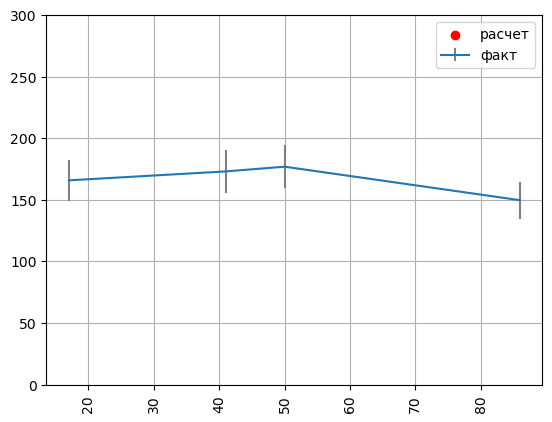

----------------roughness----------------
Параметр 0.012705
RMSE Рпл: 37801.9 бар (длина = 55.8, шероховатость = 0.012705, диаметр = 0.01200) 

1
Параметр 0.012705
RMSE Рпл: 37801.9 бар (длина = 55.8, шероховатость = 0.012705, диаметр = 0.01200) 

1
Параметр 0.0063574999999999994
RMSE Рпл: 14896.4 бар (длина = 55.8, шероховатость = 0.006357, диаметр = 0.01200) 

1
Параметр 0.0031837499999999995
RMSE Рпл: 7920.1 бар (длина = 55.8, шероховатость = 0.003184, диаметр = 0.01200) 

1
Параметр 0.0015968749999999998
RMSE Рпл: 4855.8 бар (длина = 55.8, шероховатость = 0.001597, диаметр = 0.01200) 

1
Параметр 0.0008034374999999999
RMSE Рпл: 3339.3 бар (длина = 55.8, шероховатость = 0.000803, диаметр = 0.01200) 

1
Параметр 0.00040671874999999996
RMSE Рпл: 2508.2 бар (длина = 55.8, шероховатость = 0.000407, диаметр = 0.01200) 

1
Параметр 0.000208359375
RMSE Рпл: 2010.0 бар (длина = 55.8, шероховатость = 0.000208, диаметр = 0.01200) 

1
Параметр 0.0001091796875
RMSE Рпл: 1682.0 бар (длина = 55.8

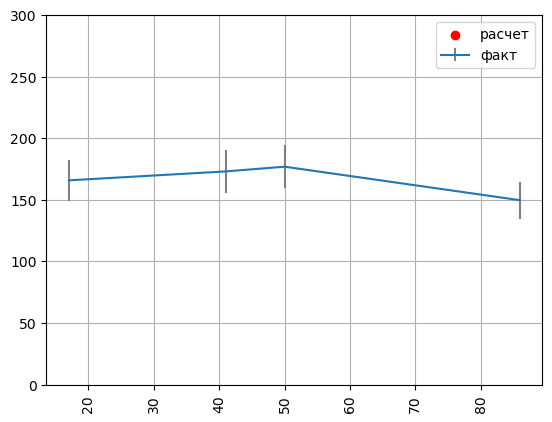

----------------length----------------
Параметр 55.8349609375
RMSE Рпл: 1102.2 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.01200) 

1
----Промежуточное решение: rmse =  1.1e+03, параметр = 55.8349609375
{'length': [11.166992187499998, 100.5029296875], 'roughness': [4.479492187499999e-06, 4.03154296875e-05], 'diameter': [0.001, 2.54]}


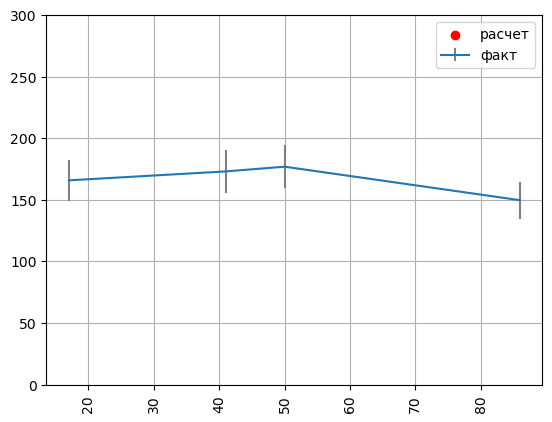

----------------diameter----------------
Параметр 1.2705
RMSE Рпл: 6.7 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 1.27050) 

-1
Параметр 1.2705
RMSE Рпл: 6.7 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 1.27050) 

-1
Параметр 0.6357499999999999
RMSE Рпл: 6.7 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.63575) 

-1
Параметр 0.31837499999999996
RMSE Рпл: 6.7 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.31837) 

-1
Параметр 0.15968749999999998
RMSE Рпл: 6.7 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.15969) 

-1
Параметр 0.08034374999999999
RMSE Рпл: 6.6 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.08034) 

-1
Параметр 0.040671874999999996
RMSE Рпл: 3.4 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

-1
Параметр 0.0208359375
RMSE Рпл: 84.1 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.02084) 

1
Параметр 0.01091796875
RMSE Рпл: 1774.4 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0

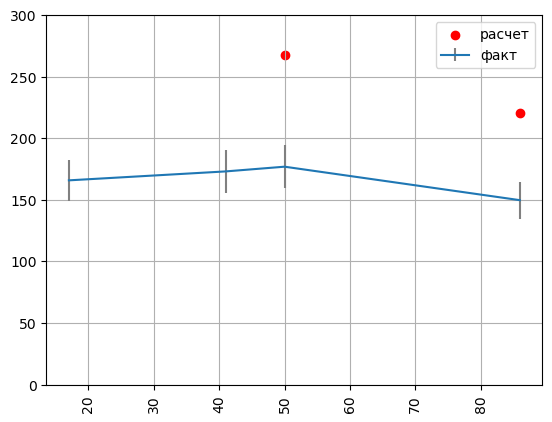

----------------length----------------
Параметр 55.8349609375
RMSE Рпл: 3.4 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

-1
Параметр 55.8349609375
RMSE Рпл: 3.4 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

-1
Параметр 78.1689453125
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 89.3359375
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 83.75244140625
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 80.960693359375
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 79.5648193359375
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 78.86688232421875
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Параметр 78.51791381835938
RMSE Рпл: 2.9 бар (длина = 55.8, шероховатость = 0.000022, диаметр = 0.04067) 

1
Пар

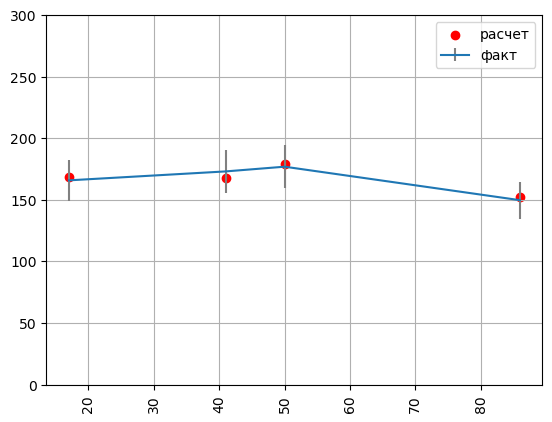

----------------roughness----------------
Параметр 2.23974609375e-05
RMSE Рпл: 2.9 бар (длина = 81.0, шероховатость = 0.000022, диаметр = 0.04067) 

1
----Промежуточное решение: rmse =  2.85, параметр = 2.23974609375e-05
{'length': [16.192138671874996, 145.729248046875], 'roughness': [4.479492187499999e-06, 4.03154296875e-05], 'diameter': [0.008134374999999998, 0.073209375]}


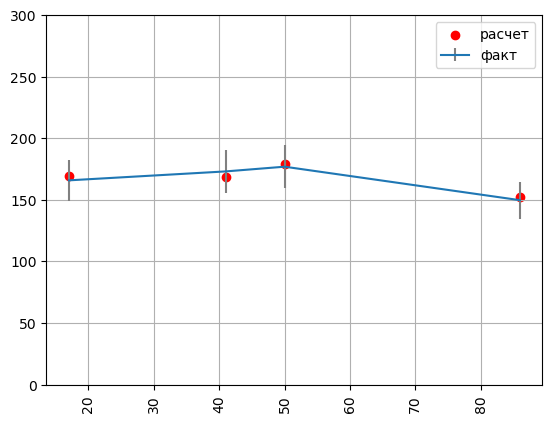

----------------length----------------
Параметр 80.960693359375
RMSE Рпл: 2.9 бар (длина = 81.0, шероховатость = 0.000022, диаметр = 0.04067) 

1
----Промежуточное решение: rmse =  2.85, параметр = 80.960693359375
{'length': [16.192138671874996, 145.729248046875], 'roughness': [4.479492187499999e-06, 4.03154296875e-05], 'diameter': [0.008134374999999998, 0.073209375]}


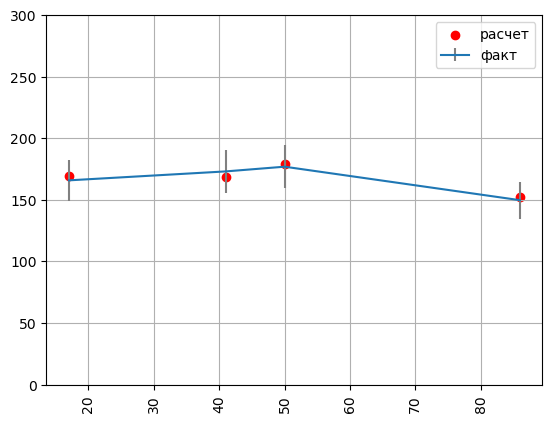

----------------roughness----------------
Параметр 2.23974609375e-05
RMSE Рпл: 2.9 бар (длина = 81.0, шероховатость = 0.000022, диаметр = 0.04067) 

1
----Промежуточное решение: rmse =  2.85, параметр = 2.23974609375e-05
{'length': [16.192138671874996, 145.729248046875], 'roughness': [4.479492187499999e-06, 4.03154296875e-05], 'diameter': [0.008134374999999998, 0.073209375]}


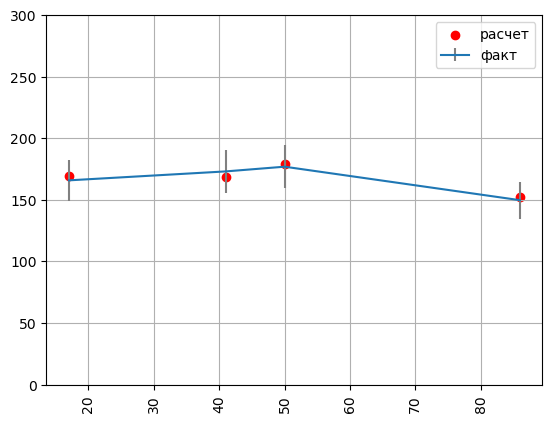

----------------length----------------
Параметр 80.960693359375
RMSE Рпл: 2.9 бар (длина = 81.0, шероховатость = 0.000022, диаметр = 0.04067) 

1
----Промежуточное решение: rmse =  2.85, параметр = 80.960693359375
{'length': [16.192138671874996, 145.729248046875], 'roughness': [4.479492187499999e-06, 4.03154296875e-05], 'diameter': [0.008134374999999998, 0.073209375]}


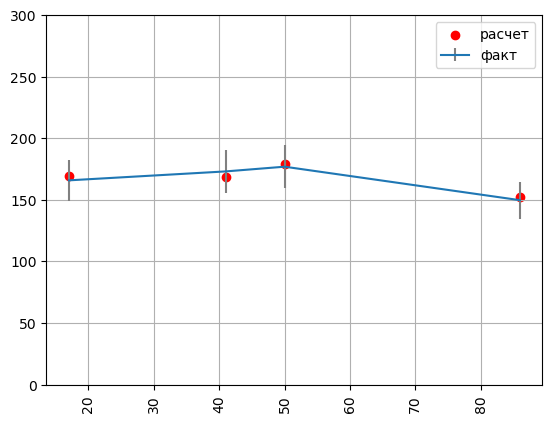

!!!Лучшее решение: rmse 2.9 бар, 
 параметры трубы: длина 80.960693359375 шероховатость 2.23974609375e-05 диаметр 0.040671874999999996


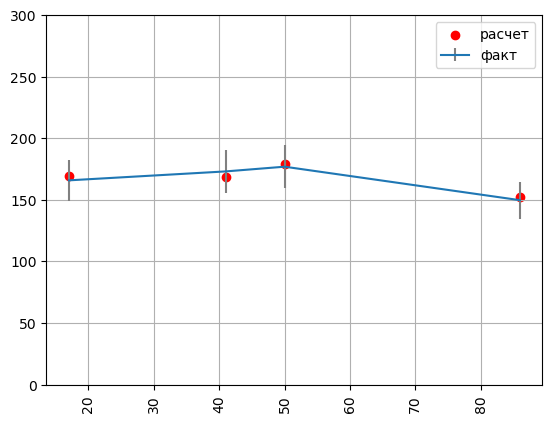

In [45]:
calculator = PressureCalculatorStepByStep(server=Server, fact_df=test_df)

# Создадим словарь с названиями и диапазоном варьируемых параметров
param_dict_init = {
      'length': [50, 12000],
      'roughness': [0.00001, 0.0254],
      'diameter': [0.001, 2.54]
}

param_dict = param_dict_init.copy()

# Присваиваем начальные значения для лучших параметров (заданы в классе)
calculator.best_length = 1000
calculator.best_diameter = 0.012
calculator.best_roughness = 0.01

ordered_params = ['length', 'roughness', 'length', 'diameter',
                  'length', 'roughness', 'length', 'roughness', 'length']

# Зададим отклонение от лучшего решения (используется для переприсваивания диапазонов)
delta = 0.8

for param_name in ordered_params:
      print(f'----------------{param_name}----------------')
      param = param_dict.get(param_name)
      err, val = calculator.half_divide_method(param[0],
                                          param[1],
                                          calculator.fit,
                                          param_dict_init,
                                          param_name,
                                          max_iter=10)

      # Динамическое присвоение значений. setattr аналогично calculator.best_length = val ()
      setattr(calculator, f'best_{param_name}', val)
      print(f'----Промежуточное решение: rmse = {err: .3}, параметр = {val}')
      
      # Переприсваиваем параметру диапазоны с учетом лучшего подобранного значения
      param_dict[param_name] = [
            getattr(calculator, f'best_{param_name}', val) * (1 - delta), 
            getattr(calculator, f'best_{param_name}', val) * (1 + delta)
      ]
      print(param_dict)
      calculator.reset_params()

      # Отобразим график с лучшими параметрами
      calculator.show_plot()

print(f'!!!Лучшее решение: rmse {round(err, 1)} бар, \n',
      f'параметры трубы: длина {calculator.best_length}',
                        f'шероховатость {calculator.best_roughness}',
                        f'диаметр {calculator.best_diameter}')

# Отобразим график с лучшими параметрами
calculator.show_plot()

### Метод Ньютона

Метод Ньютона или второе его название метод касательных, который позволяет приближенно решать уравнения вида f(x)=0. Метод Ньютона вытекает из известной в математическом анализе формуле приближенного вычисления функции f(x) одной переменной при малом приращении аргумента в окрестности точки x₀.

In [ ]:
calculator = PressureCalculator(server=Server, fact_df=test_df)

calculator.newtons_method(50, 15240, calculator.fit)

Построим график с расчетом по методу Ньютона (взяты лучшие параметры)

Параметр 419.50889771868094
Среднеквадратичная ошибка Рпл: 17.7 бар 

!!!Лучшее решение: среднеквадратичная ошибка 17.7 бар, 
                   параметры трубы 419.5089


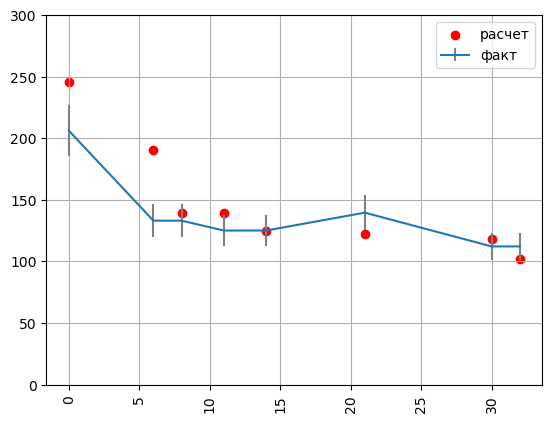

In [ ]:
# Запишем в переменные лучшие найденные параметры
rmse, params = calculator.best_params

# Подставим лучшие параметры
calculator.fit(params)
print(f'!!!Лучшее решение: среднеквадратичная ошибка {round(rmse, 1)} бар, \n', 
      f'                  параметры трубы {round(params, 4)}')

# Отобразим график с лучшими параметрами
calculator.show_plot()

Выше варьируется только длина трубы, диаметр и шероховатость неизменны

### Метод shgo библиотеки scipy

In [ ]:
calculator = PressureCalculator(server=Server, fact_df=test_df)

res = optimize.shgo(calculator.fit_shgo_1point, [(100, 1000)], 
                    options={'minimize_every_iter': True, 'local_iter': False},
                    sampling_method='sobol', n=8)


Параметр 100.0
83.35806446690714
Рпл расчетное = ['107.308198778']
Дельта: 2    25.7
Name: layer_pres_research, dtype: float64 бар 

Параметр 550.0
83.35806446690714
Рпл расчетное = ['153.003117272']
Дельта: 2    20.0
Name: layer_pres_research, dtype: float64 бар 

Параметр 775.0
83.35806446690714
Рпл расчетное = ['176.565255096']
Дельта: 2    43.6
Name: layer_pres_research, dtype: float64 бар 

Параметр 325.0
83.35806446690714
Рпл расчетное = ['131.974100379']
Дельта: 2    1.0
Name: layer_pres_research, dtype: float64 бар 

Параметр 437.5
83.35806446690714
Рпл расчетное = ['145.733423858']
Дельта: 2    12.7
Name: layer_pres_research, dtype: float64 бар 

Параметр 887.5
83.35806446690714
Рпл расчетное = ['181.645013010']
Дельта: 2    48.6
Name: layer_pres_research, dtype: float64 бар 

Параметр 662.5
83.35806446690714
Рпл расчетное = ['166.810926615']
Дельта: 2    33.8
Name: layer_pres_research, dtype: float64 бар 

Параметр 212.5
83.35806446690714
Рпл расчетное = ['121.262440807']
Дел

In [ ]:
calculator = PressureCalculator(server=Server, fact_df=test_df)

res = optimize.shgo(calculator.fit_shgo, [(100, 1000)], 
                    options={'minimize_every_iter': True, 'local_iter': False},
                    sampling_method='sobol')

Параметр 100.0
Среднеквадратичная ошибка Рпл: 35.6 бар 

Параметр 550.0
Среднеквадратичная ошибка Рпл: 29.1 бар 

Параметр 775.0
Среднеквадратичная ошибка Рпл: 52.3 бар 

Параметр 325.0
Среднеквадратичная ошибка Рпл: 16.9 бар 

Параметр 437.5
Среднеквадратичная ошибка Рпл: 19.7 бар 

Параметр 887.5
Среднеквадратичная ошибка Рпл: 69.5 бар 

Параметр 662.5
Среднеквадратичная ошибка Рпл: 44.5 бар 

Параметр 212.5
Среднеквадратичная ошибка Рпл: 23.1 бар 

Параметр 268.75
Среднеквадратичная ошибка Рпл: 19.0 бар 

Параметр 718.75
Среднеквадратичная ошибка Рпл: 48.0 бар 

Параметр 943.75
Среднеквадратичная ошибка Рпл: 67.1 бар 

Параметр 493.75
Среднеквадратичная ошибка Рпл: 30.7 бар 

Параметр 381.25
Среднеквадратичная ошибка Рпл: 17.7 бар 

Параметр 831.25
Среднеквадратичная ошибка Рпл: 59.6 бар 

Параметр 606.25
Среднеквадратичная ошибка Рпл: 43.3 бар 

Параметр 156.25
Среднеквадратичная ошибка Рпл: 28.4 бар 

Параметр 184.375
Среднеквадратичная ошибка Рпл: 25.7 бар 

Параметр 634.375
Сред